In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = only ERROR

In [2]:

from keras_preprocessing.image import ImageDataGenerator
from keras.api.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.api.applications import VGG16
from keras.api.optimizers import Adam
from PIL import ImageFile
from keras.api.models import Sequential

ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dir = r"/workspace/sdp/redd/train"
test_dir = r"/workspace/sdp/redd/test"
print("w")

E0000 00:00:1744026300.205032    6988 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744026300.211914    6988 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


w


In [3]:

# More balanced data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,  # Reduced from 30
    width_shift_range=0.1,  # Reduced from 0.15
    height_shift_range=0.1,  # Reduced from 0.15
    shear_range=0.1,  # Reduced from 0.15
    zoom_range=[0.9, 1.1],  # Reduced range
    brightness_range=[0.8, 1.2],  # Reduced range
    horizontal_flip=True,
    vertical_flip=False,  # Removed vertical flip
    channel_shift_range=10.0,  # Reduced from 20
    fill_mode='reflect'
)

# Only rescale for test
test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 15000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [6]:

# 📦 Load VGG16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Improved model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3, activation='softmax')
])
# Improved optimizer configuration
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,880,835 (56.77 MB)

 Trainable params: 165,379 (646.01 KB)

 Non-trainable params: 14,715,456 (56.14 MB)

In [7]:
import pickle

# 🚀 Train Phase 1
epochs = 5
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=epochs,
)

# 💾 Save Phase 1
model.save("model2_augmented.h5")
with open("history2-ag.pkl", "wb") as f:
    pickle.dump(history.history, f)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 248s 522ms/step - accuracy: 0.6341 - loss: 0.8885 - val_accuracy: 0.8927 - val_loss: 0.2841
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 237s 505ms/step - accuracy: 0.8504 - loss: 0.3707 - val_accuracy: 0.8980 - val_loss: 0.2555
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 230s 492ms/step - accuracy: 0.8758 - loss: 0.3100 - val_accuracy: 0.9107 - val_loss: 0.2213
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 241s 513ms/step - accuracy: 0.8951 - loss: 0.2741 - val_accuracy: 0.9223 - val_loss: 0.1932
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 244s 520ms/step - accuracy: 0.9049 - loss: 0.2462 - val_accuracy: 0.9327 - val_loss: 0.1722


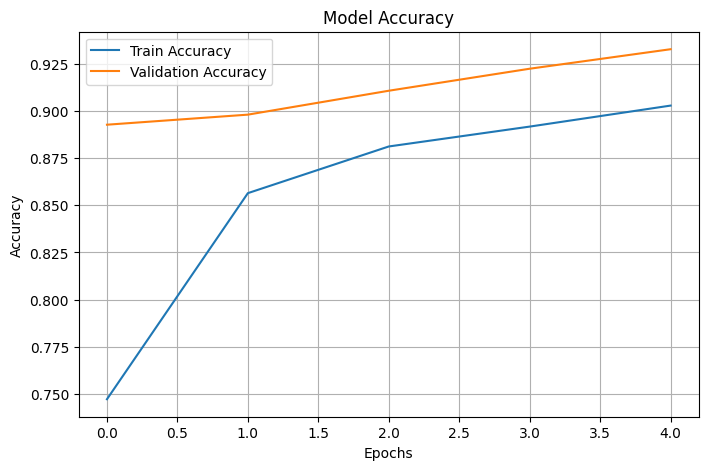

In [10]:



def plot_accuracy(history):
    plt.figure(figsize=(8, 5))  # Set figure size
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()
    plt.show(block=True)  # Force displayy


plot_accuracy(history)

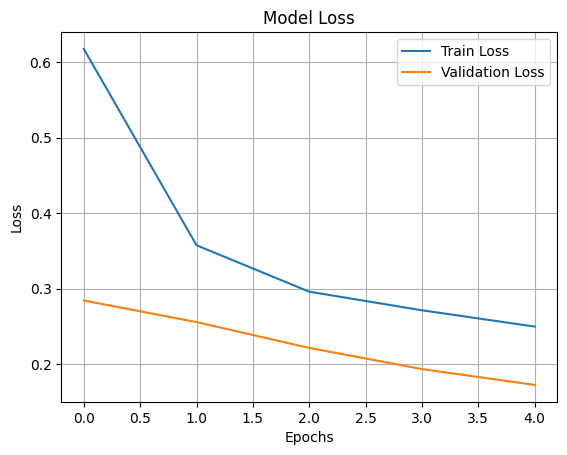

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()
    plt.show()


plot_loss(history)

In [16]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"\n🔹 Test Accuracy after initial training: {test_accuracy * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.9324 - loss: 0.1738

🔹 Test Accuracy after initial training: 95.63%


In [18]:
# 🔧 Fine-Tuning Phase
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Fine-tune last 10 layers only
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
fine_tune_epochs = 2
history_fine = model.fit(
    training_set,
    validation_data=test_set,
    epochs=fine_tune_epochs,

)

# 💾 Save Fine-tuned Model
model.save("model_finetuned_augmented.h5")
with open("history_finetuned.pkl", "wb") as f:
    pickle.dump(history_fine.history, f)

Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 250s 521ms/step - accuracy: 0.9420 - loss: 0.1517 - val_accuracy: 0.9747 - val_loss: 0.0653
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 239s 510ms/step - accuracy: 0.9645 - loss: 0.0928 - val_accuracy: 0.9840 - val_loss: 0.0393


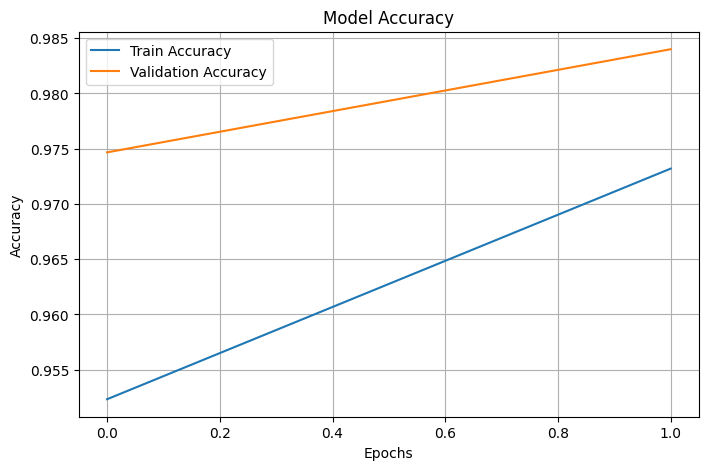

In [20]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 5))  # Set figure size
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()
    plt.show(block=True)  # Force displayy


plot_accuracy(history_fine)

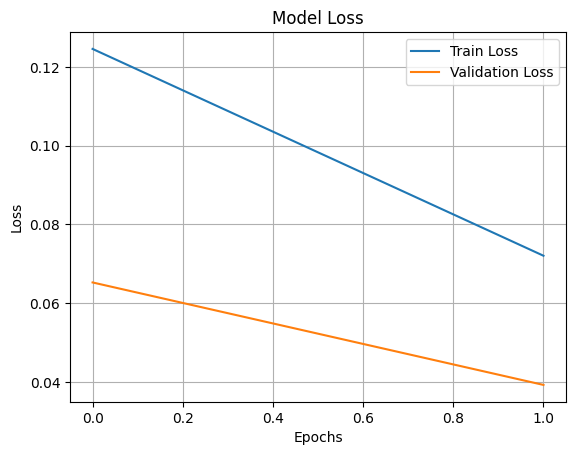

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()
    plt.show()


plot_loss(history_fine)

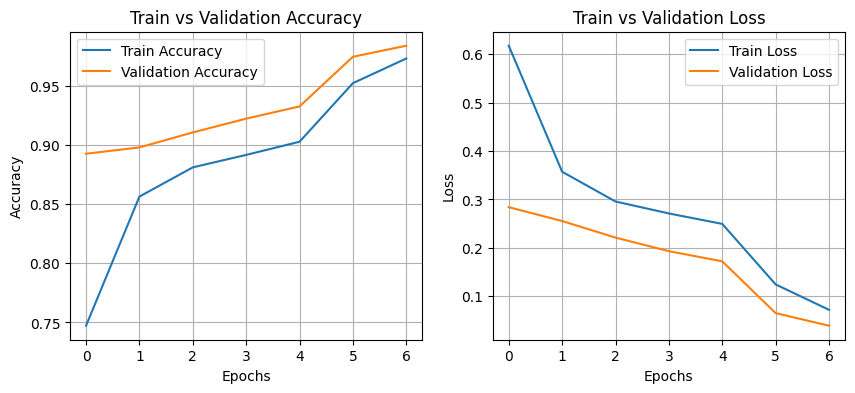

In [22]:

import matplotlib.pyplot as plt


# Function to compare training and fine-tuning performance
def plot_fine_tuning(history, history_fine):
    # Access history dictionaries
    h1 = history.history
    h2 = history_fine.history

    # Combine accuracy
    acc = h1['accuracy'] + h2['accuracy']
    val_acc = h1['val_accuracy'] + h2['val_accuracy']

    # Combine loss
    loss = h1['loss'] + h2['loss']
    val_loss = h1['val_loss'] + h2['val_loss']

    epochs_range = range(len(acc))

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid()

    plt.show()


# Call the function
plot_fine_tuning(history, history_fine)


In [1]:
from keras.api.models import load_model
from keras_preprocessing import image
import numpy as np

model = load_model('model_finetuned_augmented.h5')

test_image = image.load_img('WhatsApp Image 2025-04-08 at 17.45.30_dc3e3eb2.jpg', target_size=(224, 224))
#test_image = image.load_img('/workspace/sdp/output_hazed_noisy.jpg', target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0

result = model.predict(test_image)
class_index = np.argmax(result[0])
class_labels = {0: 'cat', 1: 'dog', 2: 'human'}
prediction = class_labels[class_index]

print(f"\n🟢 Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step

🟢 Prediction: human


In [8]:
from keras.api.models import load_model
from keras_preprocessing.image import ImageDataGenerator

loaded_model = load_model('model_finetuned_augmented.h5')

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    r"/sdp/redd/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
loss, accuracy = loaded_model.evaluate(test_generator)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Loss: {loss:.4f}")

import numpy as np
from sklearn.metrics import classification_report

y_true = test_generator.classes

y_pred_probs = loaded_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

Found 3000 images belonging to 3 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9714 - loss: 0.0704
Accuracy: 98.40%
Loss: 0.0393


94/94 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step
              precision    recall  f1-score   support

         cat       0.99      0.96      0.98      1000
         dog       0.96      0.99      0.98      1000
       human       1.00      1.00      1.00      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [1]:
from sklearn.metrics import confusion_matrix, classification_report

# Example raw data (you'd replace this with your real model output)
y_true = ['cat', 'dog', 'human', 'cat', 'dog', 'human', 'cat', 'dog', 'human']
y_pred = ['cat', 'dog', 'human', 'dog', 'dog', 'human', 'cat', 'cat', 'human']

# Define your class order to keep it consistent
labels = ['cat', 'dog', 'human']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Print nicely
print("Confusion Matrix:")
print("         Pred:Cat  Pred:Dog  Pred:Human")
for i, row in enumerate(cm):
    print(f"Actual:{labels[i]:<5} {row}")

# Optionally also print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=labels))

Confusion Matrix:
         Pred:Cat  Pred:Dog  Pred:Human
Actual:cat   [2 1 0]
Actual:dog   [1 2 0]
Actual:human [0 0 3]

Classification Report:
              precision    recall  f1-score   support

         cat       0.67      0.67      0.67         3
         dog       0.67      0.67      0.67         3
       human       1.00      1.00      1.00         3

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9

